# Home Credit Default Risk  

 
L'objectif est d'utiliser les données historiques des demandes de prêt pour prédire si un demandeur sera en mesure ou non de rembourser un prêt. Il s'agit d'une tâche de classification supervisée.

* Un point sur les données :

Elles contiennet des informations sur chaque demande de prêt. Chaque prêt a sa propre ligne et est identifié par la caractéristique `SK_ID_CURR`. Si la caractéristique `TARGET` indique 0 : le prêt a été remboursé si elle indique 1 : le prêt n'a pas été remboursé.  
 

In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# get data
train = pd.read_csv('..\\data\\application_train.csv')
test = pd.read_csv('..\\data\\application_test.csv')

print(train.shape)
train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
print(test.shape)
test.head()

(48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


L'ensemble de test ne comporte pas de colonne `TARGET`. Cela signifie que si nous voulons évaluer notre modèle sans avoir à faire de soumissions sur Kaggle à chaque fois, il nous faut un jeu de validation.

In [3]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, test_size=0.20, stratify=train['TARGET'], random_state=42)

In [4]:
train.select_dtypes('object').columns
# train.shape

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

# Basic EDA

L'objectif de l'EDA est d'apprendre ce que nos données peuvent nous dire. Elle commence généralement par une vue d'ensemble de haut niveau, puis se concentre sur des domaines spécifiques au fur et à mesure que nous trouvons des zones intrigantes dans les données.


## Distribution de la cible 

In [141]:
train['TARGET'].value_counts()

0    226148
1     19860
Name: TARGET, dtype: int64

Il y a beaucoup plus de prêts qui ont été remboursés à temps que de prêts qui n'ont pas été remboursés. Une bonne idée peut être de recourrir à des techniques de sur ou sous échantillonage. Ou meme utiliser un modèle sophistiqué afin de pondérer les classes en fonction de leur représentation dans les données.

## Valeurs manquantes

In [142]:
mis_val = train.isnull().sum()
mis_val_percent = 100.00 * train.isnull().sum() / len(train)

mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
mis_val_table_ren_columns = mis_val_table.rename(
columns = {0 : 'Missing Values', 1 : 'Percentage'})

mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
'Percentage', ascending=False).round(1)
        
mis_val_table_ren_columns.head(10)

,Missing Values,Percentage
COMMONAREA_MEDI,171811,69.8
COMMONAREA_AVG,171811,69.8
COMMONAREA_MODE,171811,69.8
NONLIVINGAPARTMENTS_MEDI,170729,69.4
NONLIVINGAPARTMENTS_MODE,170729,69.4
NONLIVINGAPARTMENTS_AVG,170729,69.4
FONDKAPREMONT_MODE,168215,68.4
LIVINGAPARTMENTS_MODE,168119,68.3
LIVINGAPARTMENTS_MEDI,168119,68.3
LIVINGAPARTMENTS_AVG,168119,68.3


Nous devrons imputer ces valeurs manquantes ou utiliser des modèles tels que XGBoost qui peuvent gérer les valeurs manquantes. Une autre option serait de supprimer les colonnes présentant un pourcentage élevé de valeurs manquantes...  

## Types de données 

In [143]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Nombre de catégories pour les variables catégorielles :

In [144]:
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## Encodage des variables catégorielles


Pour toute variable catégorielle avec 2 catégories uniques, nous utiliserons le label encoding, et pour toute variable catégorielle avec plus de 2 catégories uniques, nous utiliserons le one hot encoding. Ici, le choix est arbitraire et permet d'avoir rapidement un modèle baseline.

In [4]:
le = LabelEncoder()
le_cols = 0

for col in train:
    if train[col].dtype == 'object':
        if len(list(train[col].unique())) <= 2:
            # Train on the training data and avoid leakage
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
            val[col] = le.transform(val[col])
            test[col] = le.transform(test[col])
            
            le_cols += 1
            
print(f'{le_cols} label encoded columns.')

3 label encoded columns.


In [5]:
# one-hot encoding of categorical variables
train = pd.get_dummies(train)
val = pd.get_dummies(val)
test = pd.get_dummies(test)

print('Training Features shape: ', train.shape)
print('Training Features shape: ', val.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (246008, 243)
Training Features shape:  (61503, 242)
Testing Features shape:  (48744, 239)


### Attention aux différentes colonnes entre train et test data

Il doit y avoir les mêmes caractéristiques (colonnes) dans les deux dataframes. L'encodage one hot a créé plus de colonnes dans les données d'apprentissage parce qu'il y avait quelques variables catégorielles avec des catégories non représentées dans les données de test. Nous devons supprimer les colonnes dans les données d'apprentissage qui ne sont pas dans les données de test. 

In [6]:
# remove target 
train_labels = train['TARGET']
val_labels = val['TARGET']

# keep only columns in both dfs
train, test = train.align(test, join='inner', axis=1)
train, val = train.align(val, join='inner', axis=1)

# add back target
train['TARGET'] = train_labels
val['TARGET'] = val_labels

print('Train df shape: ', train.shape)
print('Val df shape: ', val.shape)
print('Test df shape: ', test.shape)

Train df shape:  (246008, 240)
Val df shape:  (61503, 240)
Test df shape:  (48744, 239)


La taille du dataset a explosé, nous voudrons surement réaliser un sélection des variables informatives.

### Les anomalies

Une façon de repérer les anomalies est de regarder les statistiques d'une colonne en utilisant la méthode `describe`. 


In [148]:
train.describe()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
count,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,2.460080e+05,2.460080e+05,245998.000000,2.457870e+05,246008.000000,...,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000
mean,278335.354724,0.095314,0.339806,0.693839,0.416409,1.688532e+05,5.993382e+05,27108.089708,5.386530e+05,0.020858,...,0.030377,0.007313,0.005874,0.005317,0.214847,0.210814,0.017447,0.518560,0.007549,0.080729
std,102797.868259,0.293649,0.473644,0.460898,0.719500,2.589606e+05,4.027258e+05,14520.904087,3.695950e+05,0.013835,...,0.171623,0.085202,0.076415,0.072723,0.410717,0.407888,0.130929,0.499656,0.086554,0.272419
min,100002.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189239.750000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16510.500000,2.385000e+05,0.010006,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278392.000000,0.000000,0.000000,1.000000,0.000000,1.476000e+05,5.147775e+05,24903.000000,4.500000e+05,0.018850,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,367291.750000,0.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,456255.000000,1.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment? 

In [149]:
train['DAYS_EMPLOYED'].describe()

count    246008.000000
mean      63581.163637
std      141081.696923
min      -17912.000000
25%       -2762.000000
50%       -1215.000000
75%        -291.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

La valeur maximale de jours en emploi est d'environ 1000 ans, ce qui n'a pas de sens.

Text(0.5, 0, 'Jours en emploi')

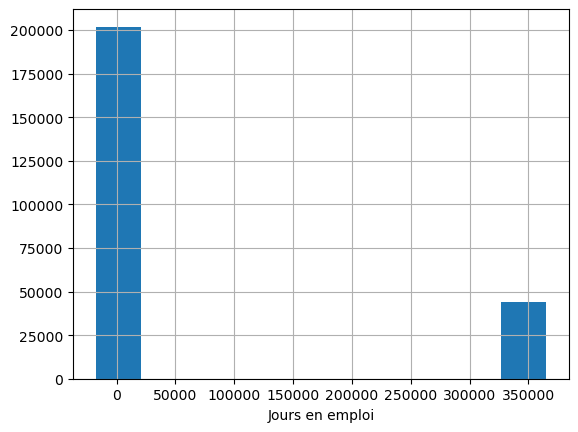

In [150]:
train['DAYS_EMPLOYED'].hist()
plt.xlabel('Jours en emploi')

Quand on rencontre des anomalies telles que celles-ci, il est possible d'imaginer que ces un phénomène aléatoire mais parfois le simple fait que la donnée soit abbérante ou meme manquante est une information en soit. Il est toujours intéressant de comparer le fait que ce soit une anomalie ou non avec la valeur de la cible.

Ici, regardons si les erreurs de saisies concernant les jours en emploi ont une corrélation avec la cible ou non ? 

In [151]:
anomalies = train[train['DAYS_EMPLOYED'] == 365243]
regular_data = train[train['DAYS_EMPLOYED'] != 365243]
print('Non anomalous observations regarding number of days employed default on %0.2f%% of loans' % (100 * regular_data['TARGET'].mean()))
print('The anomalous observations regarding number of days employed default on %0.2f%% of loans' % (100 * anomalies['TARGET'].mean()))

Non anomalous observations regarding number of days employed default on 8.66% of loans
The anomalous observations regarding number of days employed default on 5.37% of loans


Il s'avère que les anomalies du point de vue du nombre de jours en emploi ont un taux de défaut plus faible. 

L'une des approches les plus sûres consiste à définir les anomalies comme des valeurs manquantes, puis à les imputer. En effet, ici, les valeurs anormales semblent avoir une certaine importance, et nous voulons donc indiquer au modèle que nous avons imputé ces valeurs.

Text(0.5, 0, 'Jours en emploi')

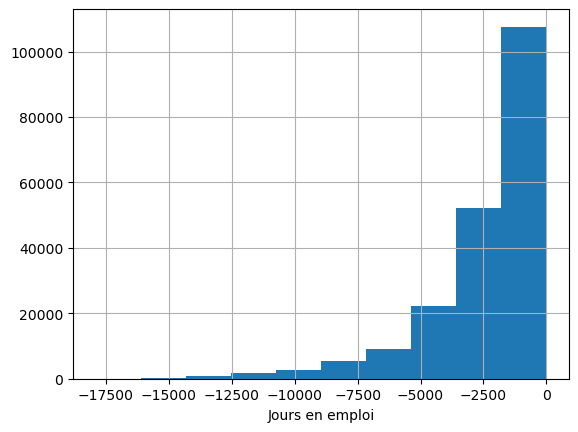

In [7]:
# on indique les valeurs abbérantes avec un booléen 
train['DAYS_EMPLOYED_ANOMALIES'] = train["DAYS_EMPLOYED"] == 365243

# on les remplace avec np.nan pour imputation ultérieure
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
train['DAYS_EMPLOYED'].hist()
plt.xlabel('Jours en emploi')

Les autres colonnes avec `DAYS` dans le cadre de données semblent être à peu près ce que nous attendons, sans aberrations évidentes. 

In [8]:
# on réplique les manipulations dans les dfs de val et de test
val['DAYS_EMPLOYED_ANOMALIES'] = val["DAYS_EMPLOYED"] == 365243
val["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
test['DAYS_EMPLOYED_ANOMALIES'] = test["DAYS_EMPLOYED"] == 365243
test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

### Etude des corrélations

  
Le coefficient de corrélation n'est pas la meilleure méthode pour représenter la "pertinence" d'une caractéristique, mais il nous donne une idée des relations possibles au sein des données. Il ne prend par exemple pas en compte les corrélations non linéaires.


In [154]:
train.corr()['TARGET'].sort_values()

EXT_SOURCE_3                           -0.178845
EXT_SOURCE_2                           -0.159593
EXT_SOURCE_1                           -0.155362
NAME_EDUCATION_TYPE_Higher education   -0.055719
CODE_GENDER_F                          -0.054576
                                          ...   
REGION_RATING_CLIENT                    0.058946
REGION_RATING_CLIENT_W_CITY             0.061283
DAYS_EMPLOYED                           0.075152
DAYS_BIRTH                              0.079467
TARGET                                  1.000000
Name: TARGET, Length: 241, dtype: float64

### Exterior Sources

Les 3 variables ayant les plus fortes corrélations négatives avec la cible sont EXT_SOURCE 1, 2 ET 3.

Text(0.5, 1.0, 'Correlation matrix')

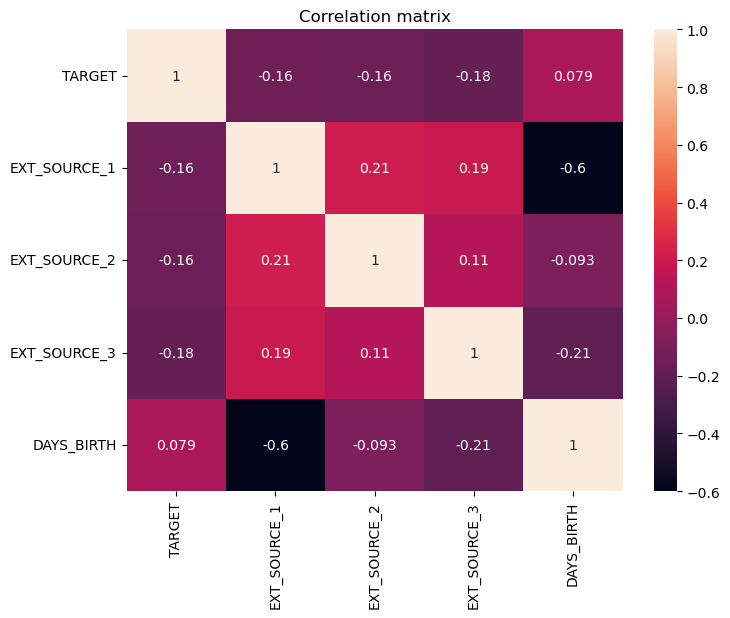

In [9]:
# Extract the EXT_SOURCE variables and show correlations
ext_sources = train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
plt.figure(figsize = (8, 6))
sns.heatmap(ext_sources.corr(), annot = True)
plt.title('Correlation matrix')

Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, ce qui indique que plus la valeur de EXT_SOURCE augmente, plus le client est susceptible de rembourser le prêt. Il s'agit surement d'indicateurs extérieurs de la solvabilité du client (autres comptes épargnes, assurances vie, placements...)

# Feature Engineering

Le Feature Engineering est souvent bien plus essentiel que la construction de modèles et le réglage des hyperparamètres. Il faut toujours mettre l'accent sur une donnée de qualité et expressive avant tout le reste.

On peut utiliser des transformations standards comme multiplier des features par des autres ou faire des ratios. Cependant, on peut aussi parler au métier et avoir leur retour sur les features qu'il serait intéressant de construire. Ici, nous ajoutons certaines features que nous avons vu revenir fréquemment dans les discusions sur le forum de Kaggle.

Features inspirées par certaines discussions sur Kaggle : 

- CREDIT_INCOME_PERCENT: % du montant du crédit par rapport au revenu, c'est la première feature qu'un conseiller clientèle va observer.
- ANNUITY_INCOME_PERCENT: % de l'annuité de prêt par rapport au revenu 
- CREDIT_TERM:  durée du paiement en mois
- DAYS_EMPLOYED_PERCENT: % des jours employés par rapport à l'âge du client, cela permet d'estimer plus précisement si le client a connu des périodes de précarité plus ou moins longue. 


In [10]:
train_enrich = train.copy()
val_enrich = val.copy()
test_enrich = test.copy()

train_enrich['CREDIT_INCOME_PERCENT'] = train_enrich['AMT_CREDIT'] / train_enrich['AMT_INCOME_TOTAL']
train_enrich['ANNUITY_INCOME_PERCENT'] = train_enrich['AMT_ANNUITY'] / train_enrich['AMT_INCOME_TOTAL']
train_enrich['CREDIT_TERM'] = train_enrich['AMT_ANNUITY'] / train_enrich['AMT_CREDIT']
train_enrich['DAYS_EMPLOYED_PERCENT'] = train_enrich['DAYS_EMPLOYED'] / train_enrich['DAYS_BIRTH']

val_enrich['CREDIT_INCOME_PERCENT'] = val_enrich['AMT_CREDIT'] / val_enrich['AMT_INCOME_TOTAL']
val_enrich['ANNUITY_INCOME_PERCENT'] = val_enrich['AMT_ANNUITY'] / val_enrich['AMT_INCOME_TOTAL']
val_enrich['CREDIT_TERM'] = val_enrich['AMT_ANNUITY'] / val_enrich['AMT_CREDIT']
val_enrich['DAYS_EMPLOYED_PERCENT'] = val_enrich['DAYS_EMPLOYED'] / val_enrich['DAYS_BIRTH']

In [11]:
test_enrich['CREDIT_INCOME_PERCENT'] = test_enrich['AMT_CREDIT'] / test_enrich['AMT_INCOME_TOTAL']
test_enrich['ANNUITY_INCOME_PERCENT'] = test_enrich['AMT_ANNUITY'] / test_enrich['AMT_INCOME_TOTAL']
test_enrich['CREDIT_TERM'] = test_enrich['AMT_ANNUITY'] / test_enrich['AMT_CREDIT']
test_enrich['DAYS_EMPLOYED_PERCENT'] = test_enrich['DAYS_EMPLOYED'] / test_enrich['DAYS_BIRTH']

# Modelling

L'objectif de l'exercice n'est pas ici la modélisation poussée néanmoins nous pouvons tester deux modèles. Un modèle linéaire très simple et un modèle plus sophistiqué.


## Logistic Regression

Implémentons d'abord le modèle de classification le plus standard. Notons que pour l'imputation des valeurs manquantes, comme pour l'encodage des variables catégorielles, nous utilisons des méthodes très rudimentaires, nous pourrions utiliser des modèles pour imputer plus précisement les valeurs manquantes.

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


# useful later
y_train = train.TARGET
y_val = val.TARGET
X_train = train.drop('TARGET', axis=1)
X_val = val.drop('TARGET', axis=1)
features = list(X_train.columns)
 
# imputation naive  
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train) 
X_train = imputer.transform(X_train)
X_val = imputer.transform(X_val)
test = imputer.transform(test)
 
# scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
test = scaler.transform(test)

print(X_train.shape)
print(X_val.shape)
print(test.shape)

(246008, 240)
(61503, 240)
(48744, 240)


In [159]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score


for c in [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]:
    # use class_weight balanced parameter here, cause of huge class imablance in the dataset
    log_reg = LogisticRegression(class_weight='balanced', C = c)
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_val)
    print('c: ', c, ': ', 'f1_score : ', f1_score(y_val, y_pred), 'accuracy_score : ', accuracy_score(y_val, y_pred))
    

c:  1 :  f1_score :  0.2601487449643632 accuracy_score :  0.6894460432824415
c:  0.1 :  f1_score :  0.2601418109961641 accuracy_score :  0.6895273401297498
c:  0.01 :  f1_score :  0.26011471089753524 accuracy_score :  0.6895761182381347
c:  0.001 :  f1_score :  0.25962023841882503 accuracy_score :  0.689982602474676
c:  0.0001 :  f1_score :  0.2586814292903875 accuracy_score :  0.6886493341788206
c:  1e-05 :  f1_score :  0.25301932367149754 accuracy_score :  0.6781945596149781


In [160]:
log_reg = LogisticRegression(class_weight='balanced', C = 0.001)
log_reg.fit(X_train, y_train)

LogisticRegression(C=0.001, class_weight='balanced')

Un paramètre lambda avec une valeur de 0.001 semble être un bon compromis ici, même si la différence est subtile. 

In [161]:
train = train.drop('TARGET', axis=1)
features = list(train.columns)

In [162]:
coef_table = pd.DataFrame(list(features))
coef_table.insert(len(coef_table.columns),"Coefs",log_reg.coef_.transpose())

In [163]:
coef_table.sort_values(by=['Coefs'])

,0,Coefs
33,EXT_SOURCE_3,-0.469033
32,EXT_SOURCE_2,-0.383156
8,AMT_GOODS_PRICE,-0.365982
31,EXT_SOURCE_1,-0.177628
2,FLAG_OWN_CAR,-0.132293
...,...,...
7,AMT_ANNUITY,0.102132
23,REGION_RATING_CLIENT_W_CITY,0.106640
83,FLAG_DOCUMENT_3,0.113146
11,DAYS_EMPLOYED,0.139318


Il nous faudrait inspecter les p-values, mais l'on constate tout de un réel importance des features AMT_GOODS_PRICE EXT_SOURCE_3, EXT_SOURCE_2 et AMT_CREDIT pour le modèle.


### Les features enrichies

Voyons maintenant l'impact des variables métiers.

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


# useful later
y_train_enrich = train_enrich.TARGET # y_train
y_val_enrich = val_enrich.TARGET # y_test
X_train_enrich = train_enrich.drop('TARGET', axis=1) # X_train
X_val_enrich = val_enrich.drop('TARGET', axis=1) # X_test
features = list(X_train_enrich.columns)
 
# imputation naive  
imputer = SimpleImputer(strategy = 'median')
imputer.fit(X_train_enrich) 
X_train_enrich = imputer.transform(X_train_enrich)
X_val_enrich = imputer.transform(X_val_enrich)
test_enrich = imputer.transform(test_enrich)
 
# scaling
scaler = StandardScaler()
scaler.fit(X_val_enrich)
X_train_enrich = scaler.transform(X_train_enrich) # X_train
X_val_enrich = scaler.transform(X_val_enrich) # X_test
test_enrich = scaler.transform(test_enrich) # test

print(X_train_enrich.shape)
print(X_val_enrich.shape)
print(test_enrich.shape)  # test = pd.read_csv('..\\data\\application_test.csv')

(246008, 244)
(61503, 244)
(48744, 244)


In [165]:
log_reg = LogisticRegression(class_weight='balanced', C=1)
log_reg.fit(X_train_enrich, y_train_enrich) # X_train, y_train
y_pred = log_reg.predict(X_val_enrich) # X_test
a = f1_score(y_val_enrich, y_pred) # y_test, y_pred
b = accuracy_score(y_val_enrich, y_pred) # y_test, y_pred
bestc1 = 1
bestc2 = 1

for c in [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]:
    # use class_weight balanced parameter here, cause of huge class imablance in the dataset
    log_reg = LogisticRegression(class_weight='balanced', C=c)
    log_reg.fit(X_train_enrich, y_train_enrich)
    y_pred = log_reg.predict(X_val_enrich)
    print('c: ', c, ': ', 'f1_score : ', f1_score(y_val_enrich, y_pred), 'accuracy_score : ', accuracy_score(y_val_enrich, y_pred))

    if a < f1_score(y_val_enrich, y_pred) :
        a = f1_score(y_val_enrich, y_pred)
        bestc1 = c
        print('new best f1_score value : '+str(a) + " => c="+str(bestc1))

    if b < accuracy_score(y_val_enrich, y_pred) : 
        b = accuracy_score(y_val_enrich, y_pred)
        bestc2 = c
        print('new best accuracy_score value : '+str(b) + " => c="+str(bestc2))

print('Best f1_score value : '+str(a) + " => c="+str(bestc1))
print('Best accuracy_score value : '+str(b) + " => c="+str(bestc2))

c:  1 :  f1_score :  0.262589368977308 accuracy_score :  0.691429686356763
c:  0.1 :  f1_score :  0.2623816177612172 accuracy_score :  0.6910069427507601
c:  0.01 :  f1_score :  0.26220080820640346 accuracy_score :  0.6912670926621466
c:  0.001 :  f1_score :  0.2624353439894217 accuracy_score :  0.6916410581597645
new best accuracy_score value : 0.6916410581597645 => c=0.001
c:  0.0001 :  f1_score :  0.2602585504095656 accuracy_score :  0.6901777149082159
c:  1e-05 :  f1_score :  0.2526942497550682 accuracy_score :  0.677544184836512
Best f1_score value : 0.262589368977308 => c=1
Best accuracy_score value : 0.6916410581597645 => c=0.001


On constate une légère amélioration pour les deux métriques avec les variables métiers.

In [166]:
# print(train_enrich.shape) # train
# print(X_train_enrich.shape) # X_train
# print(y_train_enrich.values.reshape(y_train_enrich.shape[0], 1).shape) # y_train

# print(val_enrich.shape) # test
# print(X_val_enrich.shape) # X_test
# print(y_val_enrich.values.reshape(y_val_enrich.shape[0], 1).shape) # y_test

(246008, 245)
(246008, 244)
(246008, 1)
(61503, 245)
(61503, 244)
(61503, 1)


In [167]:
# log_reg = LogisticRegression(class_weight='balanced', C=0.001)
# log_reg.fit(X_train_enrich, y_train_enrich)
# y_pred = log_reg.predict(X_val_enrich) # y_pred = log_reg.predict(X_test)

# print(y_pred.reshape(y_pred.shape[0], 1).shape)

(61503, 1)


In [168]:
# # Create the dataframe from numpy.ndarray
# X_val_enrich = val_enrich.drop('TARGET', axis=1) # X_test
# features = list(X_val_enrich.columns)

# X_val_enrich_df = pd.DataFrame(X_val_enrich, columns=features)
# y_val_enrich_df = pd.DataFrame(y_val_enrich, columns=['y_test'])
# y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])

# # # Add y_test & y_pred columns to the X_test dataset
# test_df = X_val_enrich_df.join(y_val_enrich_df).join(y_pred_df)

# URL = r'..\\data\\final_test_df.csv'
# test_df.to_csv(URL, sep=";", index=False, header=True)

# LGBM

Le Gradient Boosting Machine est un type de modèle plus complexe qui est acutellement l'état de l'art sur des jeux de données tabulaires.  

In [169]:
from sklearn.metrics import roc_auc_score
import lightgbm as lgb


# Create the model
model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                            class_weight = 'balanced', learning_rate = 0.05, 
                            reg_alpha = 0.1, reg_lambda = 0.1, 
                            subsample = 0.8, n_jobs = -1, random_state = 50)

# Train the model
model.fit(X_train, y_train, eval_metric = 'auc',
            eval_set = [(X_val, y_val), (X_train, y_train)],
            eval_names = ['valid', 'train'],
            early_stopping_rounds = 500, verbose = 200)

best_model = model.best_iteration_


Training until validation scores don't improve for 500 rounds
[200]	train's auc: 0.796072	train's binary_logloss: 0.550589	valid's auc: 0.760244	valid's binary_logloss: 0.563353
[400]	train's auc: 0.825529	train's binary_logloss: 0.521816	valid's auc: 0.75987	valid's binary_logloss: 0.546027
[600]	train's auc: 0.84943	train's binary_logloss: 0.497085	valid's auc: 0.759491	valid's binary_logloss: 0.530512
Early stopping, best iteration is:
[245]	train's auc: 0.803456	train's binary_logloss: 0.543464	valid's auc: 0.760576	valid's binary_logloss: 0.558932


In [170]:
# get preds 
y_pred = model.predict(X_val, num_iteration = best_model)

# get score
from sklearn.metrics import f1_score, accuracy_score
print('f1_score: ', f1_score(y_val, y_pred), 'accuracy_score: ', accuracy_score(y_val, y_pred))

f1_score:  0.27392887834022184 accuracy_score:  0.7115100076419036


### Avec les features enrichies

In [171]:
# train_enrich = train_enrich.iloc[0:10]
# val_enrich = val_enrich.iloc[0:10]

In [172]:
# y_train_enrich = train_enrich.TARGET # y_train
# y_val_enrich = val_enrich.TARGET # y_test
# X_train_enrich = train_enrich.drop('TARGET', axis=1) # X_train
# X_val_enrich = val_enrich.drop('TARGET', axis=1) # X_test
# features = list(X_train_enrich.columns)

In [173]:
# print(y_train_enrich.shape, y_val_enrich.shape, X_train_enrich.shape, X_val_enrich.shape)

In [174]:
# import pandas as pd

# y_train_enrich = pd.DataFrame(y_train_enrich, columns=['TARGET'])
# y_val_enrich = pd.DataFrame(y_val_enrich, columns=['TARGET'])

# # y_train_enrich = y_train_enrich.reshape(y_train_enrich.shape[0], 1)
# print(y_train_enrich.shape, y_val_enrich.shape, X_train_enrich.shape, X_val_enrich.shape)

In [14]:
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

# Create the model
model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                            class_weight = 'balanced', learning_rate = 0.05, 
                            reg_alpha = 0.1, reg_lambda = 0.1, 
                            subsample = 0.8, n_jobs = -1, random_state = 50)

# Train the model
model.fit(X_train_enrich, y_train_enrich, eval_metric = 'auc',
            eval_set = [(X_val_enrich, y_val_enrich), (X_train_enrich, y_train_enrich)],
            eval_names = ['valid', 'train'],
            early_stopping_rounds = 500, verbose = 200)

best_model = model.best_iteration_

Training until validation scores don't improve for 500 rounds
[200]	train's auc: 0.802195	train's binary_logloss: 0.544287	valid's auc: 0.767622	valid's binary_logloss: 0.557355
[400]	train's auc: 0.832347	train's binary_logloss: 0.513723	valid's auc: 0.76885	valid's binary_logloss: 0.538206
[600]	train's auc: 0.856533	train's binary_logloss: 0.488071	valid's auc: 0.768564	valid's binary_logloss: 0.522071
[800]	train's auc: 0.876662	train's binary_logloss: 0.46522	valid's auc: 0.768024	valid's binary_logloss: 0.507704
Early stopping, best iteration is:
[410]	train's auc: 0.833613	train's binary_logloss: 0.512415	valid's auc: 0.76895	valid's binary_logloss: 0.537341


In [16]:
# get preds 
y_pred = model.predict(X_val_enrich, num_iteration = best_model)

# get score
from sklearn.metrics import f1_score, accuracy_score
print('f1_score: ', f1_score(y_val_enrich, y_pred), 'accuracy_score: ', accuracy_score(y_val_enrich, y_pred))

f1_score:  0.2828162291169451 accuracy_score:  0.7263873306993155


Ici, on constate que LGBM est clairement a même d'apporter des améliorations nettes en terme de performance. Un fois encore les features métiers montrent bien la force de la connaissance du domaine dans l'amélioration des résultats.

### Feature Importances

<AxesSubplot:>

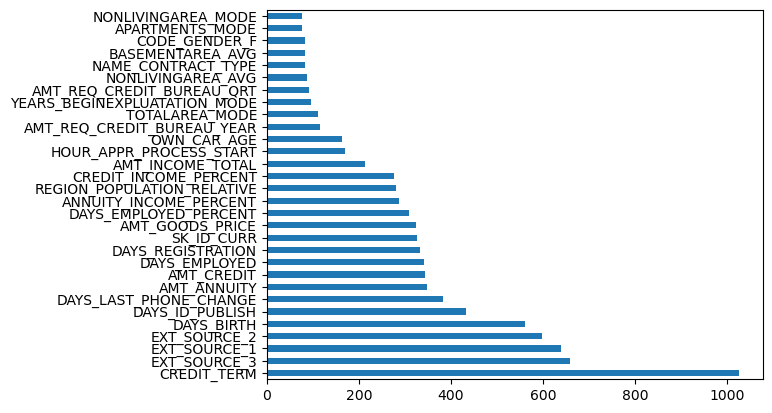

In [17]:
feat_importances = pd.Series(model.feature_importances_, index=features)
feat_importances.nlargest(30).plot(kind='barh')

On constate que les variables CREDIT_TERM, EXT_SOURCE3, EXT_SOURCE2 et EXT_SOURCE... L'age a également un fort impact avec la variable DAYS_BIRTH...

# Shap

### 1. Build a TreeExplainer and compute Shaplay Values

In [18]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_val_enrich)

print(shap_values)

[array([[-0.00981272, -0.03917561,  0.08313043, ...,  0.00954431,
         0.16308017, -0.1206272 ],
       [-0.00717919, -0.03833555, -0.04134164, ..., -0.03855807,
        -0.3822051 ,  0.04962045],
       [-0.01474751, -0.02315284, -0.08453362, ...,  0.01636057,
         0.00993238, -0.06316384],
       ...,
       [ 0.01550593, -0.02499392,  0.07053301, ...,  0.03363119,
         0.24965239, -0.03521097],
       [-0.03014898, -0.02906988,  0.08918621, ...,  0.01808118,
        -0.17235684, -0.03498133],
       [ 0.00069457, -0.02073138,  0.10557861, ...,  0.0171589 ,
         0.20540906, -0.04137522]]), array([[ 0.00981272,  0.03917561, -0.08313043, ..., -0.00954431,
        -0.16308017,  0.1206272 ],
       [ 0.00717919,  0.03833555,  0.04134164, ...,  0.03855807,
         0.3822051 , -0.04962045],
       [ 0.01474751,  0.02315284,  0.08453362, ..., -0.01636057,
        -0.00993238,  0.06316384],
       ...,
       [-0.01550593,  0.02499392, -0.07053301, ..., -0.03363119,
        

### 2. Visualize explanations for a specific point of your data set

In [36]:
import pandas as pd

X_val_enrich_ = pd.DataFrame(X_val_enrich, columns=features)

In [37]:
row_to_show = 10
data_for_prediction = X_val_enrich_.iloc[9:10]  # use 1 row of data here. Could use multiple rows if desired
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

model.predict_proba(data_for_prediction_array)

# data_for_prediction.shape

array([[0.46817064, 0.53182936]])

In [21]:
# data_for_prediction_ = pd.DataFrame(data_for_prediction, columns=features)

# print(data_for_prediction_.shape)
# data_for_prediction_.values.reshape(1, data_for_prediction_.shape[1])

In [38]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer_ = shap.TreeExplainer(model)

# Calculate Shap values
shap_values_ = explainer_.shap_values(data_for_prediction)

In [39]:
shap.initjs()
shap.force_plot(explainer_.expected_value[0], shap_values_[0], data_for_prediction)

### 3. Visualize explanations for all points of your data set at once

In [40]:
feature_names = ['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']

In [41]:
import pandas as pd

X_val_enrich_ = pd.DataFrame(X_val_enrich, columns=features)

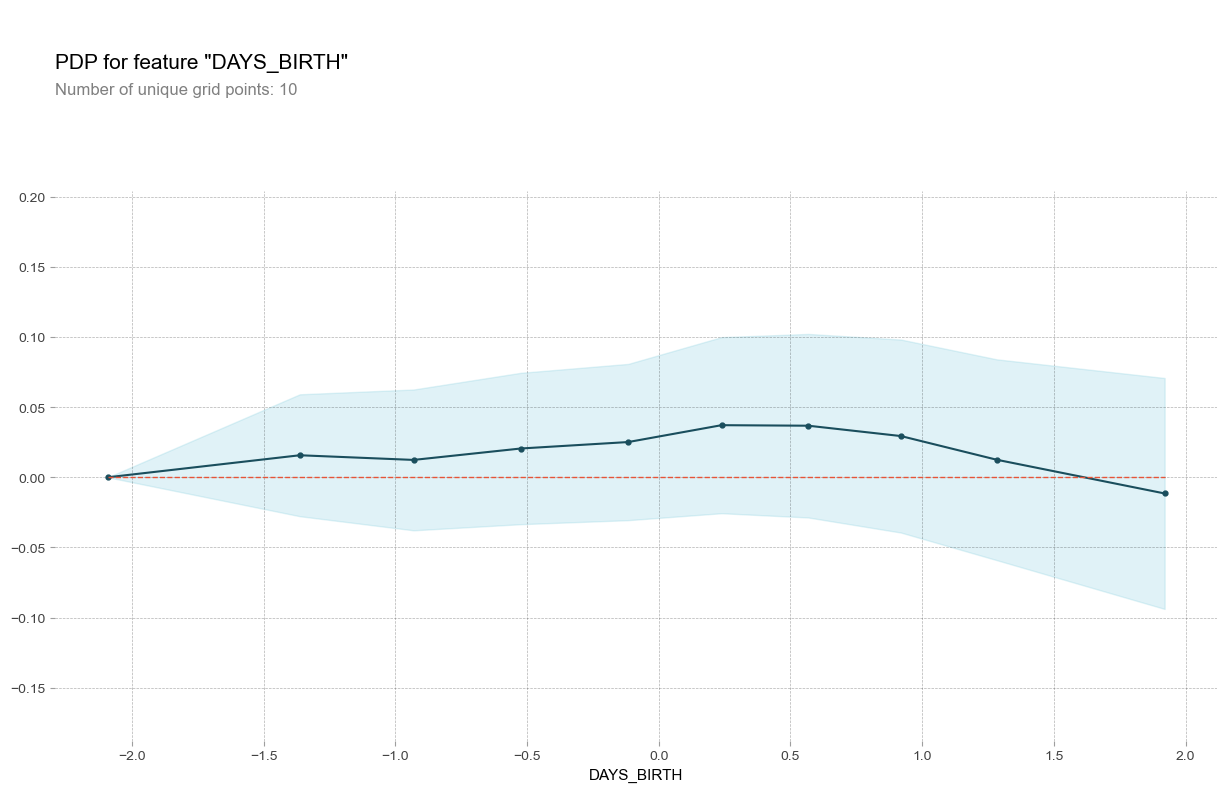

In [42]:
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=model, dataset=X_val_enrich_, model_features=features, feature='DAYS_BIRTH')

# plot it
pdp.pdp_plot(pdp_goals, 'DAYS_BIRTH')
plt.show()

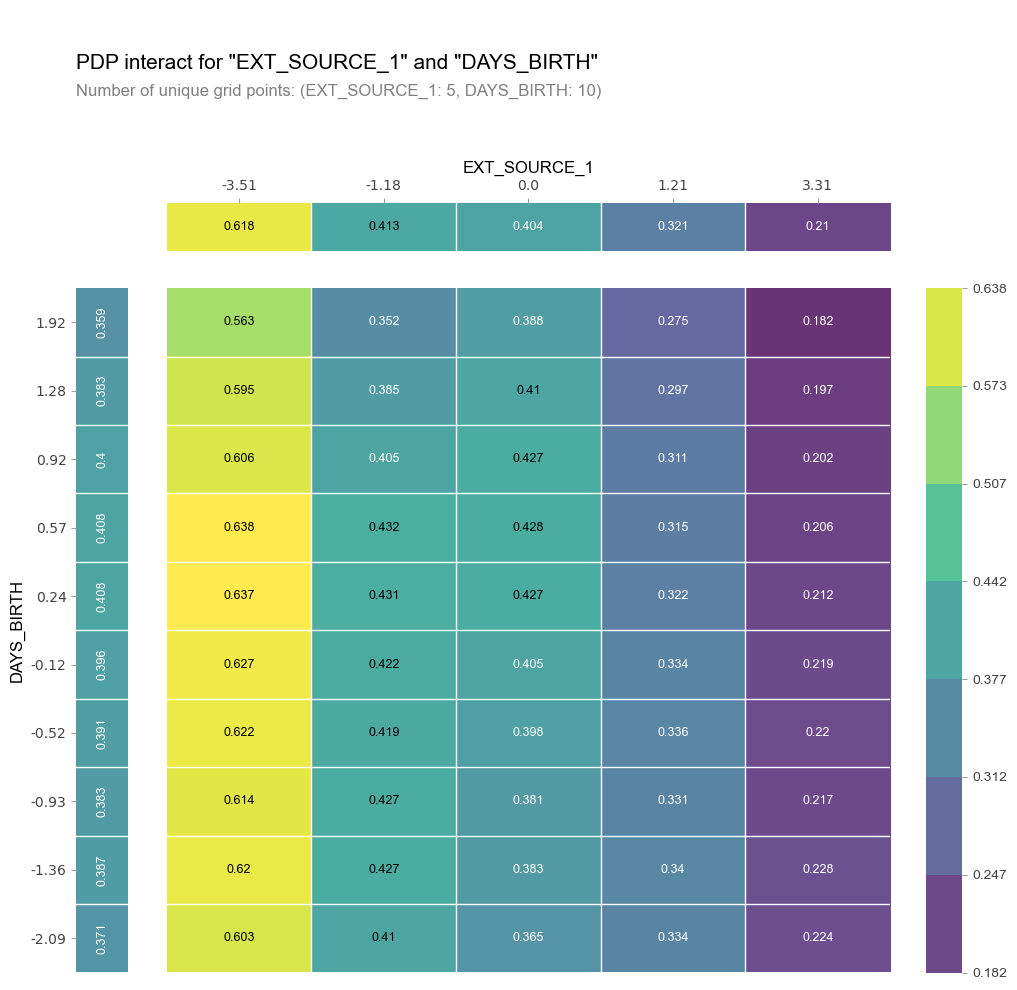

In [43]:
from pdpbox import pdp, get_dataset, info_plots

features_to_plot = ['EXT_SOURCE_1', 'DAYS_BIRTH']
inter1 = pdp.pdp_interact(model=model, dataset=X_val_enrich_, model_features=features, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid', plot_pdp=True)

# we use plot_type='grid' as the default and better option 'contour' has a bug which is being corrected
# cf. https://github.com/SauceCat/PDPbox/issues/40
plt.show()

### 4. Visualize a summary plot for each class on the whole dataset

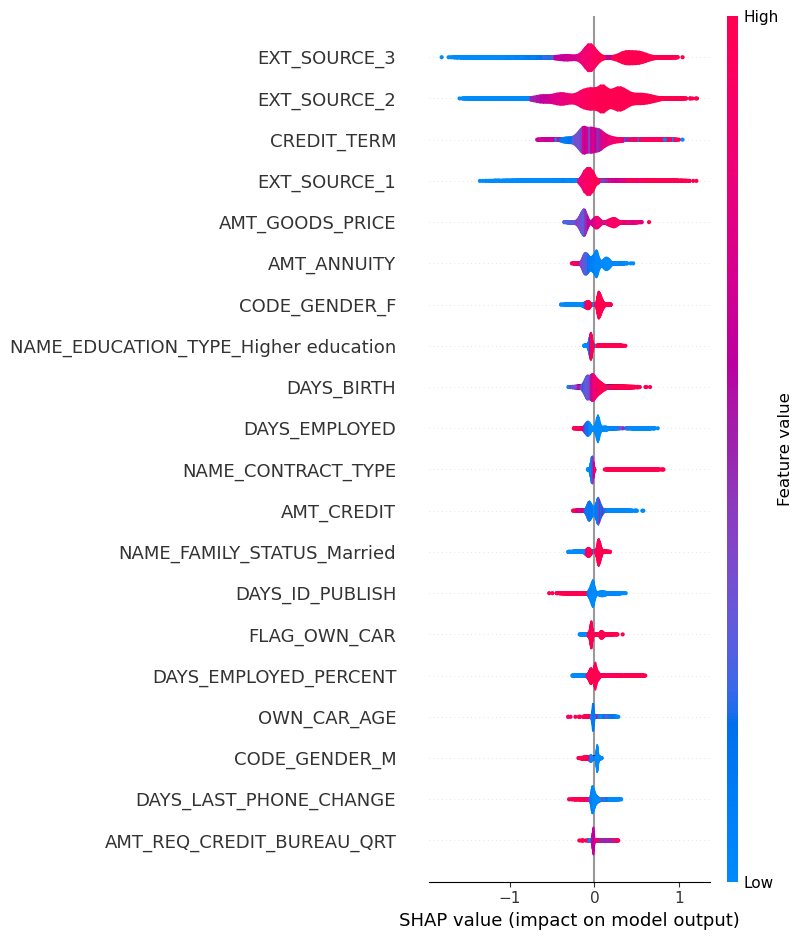

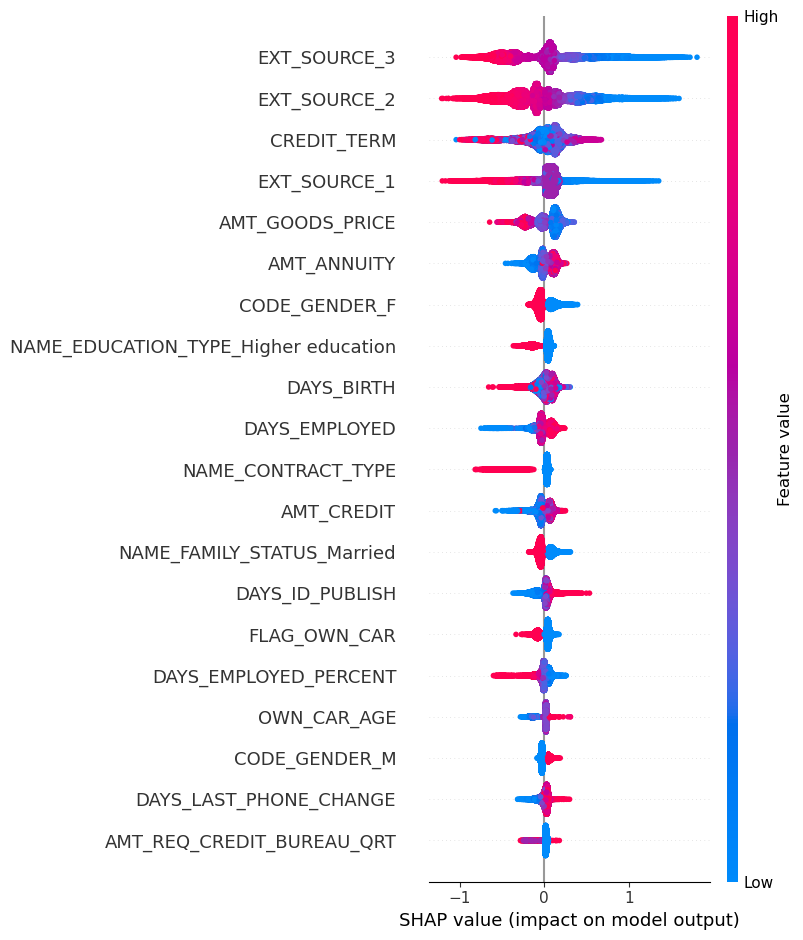

In [44]:
shap.summary_plot(shap_values[0], X_val_enrich, plot_type='violin')
shap.summary_plot(shap_values[1], X_val_enrich)